In [1]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from gPhoton import galextools as gt
plt.rcParams.update({'font.size': 18})

In [2]:
# Import the function definitions that accompany this notebook tutorial.
nb_funcdef_file = "function_defs.py"
if os.path.isfile(nb_funcdef_file):
    from function_defs import listdir_contains, read_lightcurve, refine_flare_ranges, calculate_flare_energy
    from function_defs import is_left_censored, is_right_censored, is_peak_censored, peak_flux, peak_time
else:
    raise IOError("Could not find function definition file '" + nb_funcdef_file + "' that goes with this notebook.")

In [3]:
# Restore the output directory.  Note: this assumes you've run the "generate_products" notebook already.  If not you
# will need to specify the location of the products made from the "generate_products" notebook.
%store -r data_directory
# If you have not run the "generate_products" notebook during this session, uncomment the line below and specify
# the location of the output products.
data_directory = "./raw_files/"

no stored variable or alias data_directory


In [4]:
# Restore the distance parameter.  Note: this assumes you've run the "generate_products" notebook already.  If not you
# will need to specify the distance to use.
%store -r distance
# If you have not run the "generate_products" notebook during this session, uncomment the line below and specify
# the distance to the system in parsecs.
distance = 1/(372.1631/1000) # parsecs

no stored variable or alias distance


In [5]:
# Locate the photon files.
photon_files = {'NUV':listdir_contains(data_directory,'nd-30s.csv'),
                'FUV':listdir_contains(data_directory,'fd-30s.csv')}

In [29]:
def get_flareranges_byhand(flare_num, orig_flare_ranges, lc_nuv):
    """
    In this notebook, we are going to break up flare events into individual flares based on the presence of peaks.
    This is an alternative to our algorithm that defines a single flare event based on a return of the flux to the
    INFF value.  Instead, we break them up into components to consider the scenario where a complex flare morphology
    is composed of multiple individual flares instead of a single flare with a complex shape.
    
    The orig_flare_ranges is the flare range as defined by the original algorithm, in case there is a single peak
    and we don't need to modify it at all.
    
    If we modify the flare range by hand, then we need to turn off the extra checking about 3-sigma passes, since
    if we split it into components those components won't necessarily pass those checks done by the original
    algorithm used to define the flare range in the first place.
    """
    modded = False
    if flare_num==0:
        flare_ranges = orig_flare_ranges
    elif flare_num==1:
        flare_ranges = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                        [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
                        [48, 49, 50, 51, 52, 53, 54, 55, 56]]
        modded=True
    elif flare_num==2:
        flare_ranges = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
                        [42, 43, 44, 45, 46, 47, 48, 49], [50, 51, 52, 53, 54, 55, 56]]
        modded=True
    elif flare_num==3:
        flare_ranges = orig_flare_ranges
    elif flare_num==4:
        flare_ranges = orig_flare_ranges
    elif flare_num==5:
        flare_ranges = orig_flare_ranges
    elif flare_num==6:
        flare_ranges = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
                        [30, 31, 32, 33, 34, 35],
                        [37, 38, 39, 40, 41, 42, 43, 44]]
        modded=True
    elif flare_num==7:
        flare_ranges = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
                        [36, 37, 38, 39, 40], [41, 42, 43],
                        [44, 45, 46, 47, 48, 49, 50, 51], [52, 53, 54, 55, 56]]
        modded=True
    elif flare_num==8:
        flare_ranges = [[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
                        [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]]
    else:
        raise ValueError("More flares than expected passed to function.")

    return (flare_ranges, modded)

In [30]:
# Also creates the figures used in the Appendix.
flare_table = pd.DataFrame()
n_visits = 9 # The last visit does not have a real flare in it that satisifes our basic criteria.
for i in np.arange(n_visits):
    lc_nuv = read_lightcurve(photon_files['NUV'][i])
    lc_fuv = read_lightcurve(photon_files['FUV'][i])
    (flare_ranges, quiescence, quiescence_err) = refine_flare_ranges(lc_nuv, makeplot=False)
    # Search for FUV flares, but use the NUV flare ranges rather than searching for new flare ranges
    # based on the FUV light curve (a good choice for GJ 65, but not necessarily the case in general).
    (flare_ranges_fuv, quiescence_fuv, quiescence_err_fuv) = refine_flare_ranges(lc_fuv, makeplot=False,
                                                                                 flare_ranges=flare_ranges)
    
    # Override the algorithmic flare ranges by-hand instead, in this notebook.
    (flare_ranges, modded) = get_flareranges_byhand(i, flare_ranges, lc_nuv)
    
    fig = plt.figure(figsize=(10, 8), constrained_layout=False)
    gs = fig.add_gridspec(2, len(flare_ranges), height_ratios=[1,2], hspace=0.4)
    ax1 = fig.add_subplot(gs[0,:])
    # Ignore any data points that have bad time bins.  NOTE: THIS ASSUMES A 30-SECOND BIN SIZE.
    where_plot_fuv_full = np.where(lc_fuv['expt'] >= 20.0)[0]
    where_plot_nuv_full = np.where(lc_nuv['expt'] >= 20.0)[0]
    ax1.set_title('Visit #{i} - Full Light Curve'.format(i=i+1))
    ax1.errorbar((lc_fuv['t0']-min(lc_nuv['t0']))[where_plot_fuv_full], lc_fuv['flux'][where_plot_fuv_full],
                 yerr=1.*lc_fuv['flux_err'][where_plot_fuv_full], fmt='-bo')
    ax1.errorbar((lc_nuv['t0']-min(lc_nuv['t0']))[where_plot_nuv_full], lc_nuv['flux'][where_plot_nuv_full],
                 yerr=1.*lc_nuv['flux_err'][where_plot_nuv_full], fmt='-ko')
    ylim = [min([min((lc_nuv['flux']-4*lc_nuv['flux_err'])[where_plot_nuv_full]),
                       min((lc_fuv['flux']-4*lc_fuv['flux_err'])[where_plot_fuv_full])]),
                  max([max((lc_nuv['flux']+4*lc_nuv['flux_err'])[where_plot_nuv_full]),
                       max((lc_fuv['flux']+4*lc_fuv['flux_err'])[where_plot_fuv_full])])]
    n_found = 0
    for flare_range in flare_ranges:
        nuv_3sig = np.array(flare_range)[np.where((np.array(lc_nuv['cps'].iloc[flare_range].values)-
                             3*np.array(lc_nuv['cps_err'].iloc[flare_range].values) >= quiescence))[0]].tolist()
        fuv_3sig = np.array(flare_range)[np.where((np.array(lc_fuv['cps'].iloc[flare_range].values)-
                             3*np.array(lc_fuv['cps_err'].iloc[flare_range].values) >= quiescence_fuv))[0]].tolist()
        # Check that flux is simultaneously >3-sigma above quiescence in both bands (dual-band detection criteria),
        # or there are at least TWO NUV fluxes at >3-sigma above quiescence (single-band detection criteria).
        if not modded:
            real = (any(set(nuv_3sig) & set(fuv_3sig)) or len(nuv_3sig)>1) # force detection conditions
        else:
            real = True
        if not real:
            continue
        # Add a panel for the zoom-in view.  No visit has more than three real flares in it.
        n_found += 1
        subax = fig.add_subplot(gs[1,n_found-1])
        flare_data = {'visit_num':i,'flare_num':len(flare_table)+1,'duration':len(flare_range)*30}
        # We pass the NUV quiescence values because we want to use the flare ranges found in the
        # NUV flare search for *both* NUV and FUV.  So we do NOT pass a quiescence parameter when
        # calling the FUV energy calculation.
        energy_nuv = calculate_flare_energy(lc_nuv, flare_range, distance, binsize=30, band='NUV',
                           quiescence=[quiescence, quiescence_err])
        energy_fuv = calculate_flare_energy(lc_fuv, flare_range, distance, binsize=30, band='FUV')
        nuv_sn = max(((np.array(lc_nuv['cps'].iloc[flare_range].values) -
                       3*np.array(lc_nuv['cps_err'].iloc[flare_range].values)) / quiescence))
        flare_data['energy_nuv'] = energy_nuv[0]
        flare_data['energy_err_nuv'] = energy_nuv[1]
        flare_data['energy_fuv'] = energy_fuv[0]
        flare_data['energy_err_fuv'] = energy_fuv[1]
        flare_data['nuv_sn'] = nuv_sn
        # If the flare is detected because it has at least one FUV and one NUV at the same time
        # above 3*INFF, this will be True.
        flare_data['detmeth_nf'] = any(set(nuv_3sig) & set(fuv_3sig))
        # If the flare is detected because it has at least two NUV fluxes that are both
        # above 3*INFF, this will be True.
        flare_data['detmeth_nn'] = len(nuv_3sig) > 1
        flare_data['left_censored'] = is_left_censored(flare_range)
        flare_data['right_censored'] = is_right_censored(lc_nuv,flare_range)
        flare_data['peak_flux_nuv'] = peak_flux(lc_nuv,flare_range)
        flare_data['peak_t0_nuv'] = peak_time(lc_nuv,flare_range)
        flare_data['peak_censored'] = is_peak_censored(lc_nuv,flare_range)
        flare_data['peak_flux_fuv'] = peak_flux(lc_fuv,flare_range)
        flare_data['peak_t0_fuv'] = peak_time(lc_fuv,flare_range)
        flare_data['quiescence_nuv'] = quiescence
        flare_data['quiescence_err_nuv'] = quiescence_err
        flare_data['quiescence_fuv'] = quiescence_fuv
        flare_data['quiescence_err_fuv'] = quiescence_err_fuv
        flare_data['flare_range'] = flare_range
        flare_table = flare_table.append(flare_data,ignore_index=True)
        # Make plots
        commentstr = 'Truncation: '
        if flare_data['left_censored']:
            commentstr += 'Left;'
        if flare_data['right_censored']:
            commentstr += 'Right;'
        if flare_data['peak_censored']:
            commentstr += 'Peak;'
        detectstr = 'Detection: '
        if flare_data['detmeth_nf']:
            detectstr += 'FUV+NUV;'
        if flare_data['detmeth_nn']:
            detectstr += 'Multi NUV;'
        # Added too much buffer in x-direction, use x-labels to identify what part of a visit
        # this flare comes from.
        t_buffer = 30.
        # Ignore any data points that have bad time bins.  NOTE: THIS ASSUMES A 30-SECOND BIN SIZE.
        where_plot_fuv = list(set(list(np.where(lc_fuv['expt'] >= 20.0)[0])).intersection(flare_range))
        where_plot_nuv = list(set(list(np.where(lc_nuv['expt'] >= 20.0)[0])).intersection(flare_range))
        where_plot_fuv.sort()
        where_plot_nuv.sort()
        subax.errorbar((lc_fuv['t0'].iloc[where_plot_fuv]-min(lc_nuv['t0'])),
                       lc_fuv['flux'].iloc[where_plot_fuv],
                       yerr=1.*lc_fuv['flux_err'].iloc[where_plot_fuv], fmt='bo-', label="FUV")
        subax.errorbar((lc_nuv['t0']-min(lc_nuv['t0'])).iloc[where_plot_nuv],
                       lc_nuv['flux'].iloc[where_plot_nuv],
                       yerr=1.*lc_nuv['flux_err'].iloc[where_plot_nuv], fmt='ko-', label="NUV")
        subax.set_xlim([lc_nuv['t0'].iloc[flare_range].min()-min(lc_nuv['t0'])-t_buffer,
                      lc_nuv['t1'].iloc[flare_range].max()-min(lc_nuv['t0'])+t_buffer])
        subax.set_ylim([min((lc_nuv['flux']-4*lc_nuv['flux_err']).iloc[flare_range].min(),
                        (lc_fuv['flux']-4*lc_fuv['flux_err']).iloc[flare_range].min()),
                    max((lc_nuv['flux']+4*lc_nuv['flux_err']).iloc[flare_range].max(),
                        (lc_fuv['flux']+4*lc_fuv['flux_err']).iloc[flare_range].max())])
        subax.hlines(gt.counts2flux(quiescence,'NUV'), lc_nuv['t0'].min()-min(lc_nuv['t0']),
                   lc_nuv['t0'].max()-min(lc_nuv['t0']), label='NUV quiescence',linestyles='dashed',color='k')
        vlinecolor = 'black'
        if n_found == 2:
            vlinecolor = "dimgrey"
        ax1.vlines(lc_nuv['t0'].iloc[flare_range].min()-min(lc_nuv['t0']), -999, 999, color=vlinecolor)
        ax1.vlines(lc_nuv['t0'].iloc[flare_range].max()-min(lc_nuv['t0']), -999, 999, color=vlinecolor)
        ax1.text((lc_nuv['t0'].iloc[flare_range].max() - lc_nuv['t0'].iloc[flare_range].min())/2.-min(lc_nuv['t0']) +
                 lc_nuv['t0'].iloc[flare_range].min(), ylim[1]*0.95,
                 "Flare #{m}".format(m=len(flare_table)), color=vlinecolor)
        subax.set_title('Flare #{m}'.format(m=len(flare_table)))
        subax.legend(ncol=2, fontsize=8)
    ax1.set_ylim(ylim)
    ax1.set_xlabel('Seconds (from start of visit)')
    ax1.set_ylabel('Flux (erg/s/cm^2)')
    fig.savefig('figures/visit_{i}_byhand.eps'.format(i=i+1), dpi=600)
    plt.close(fig)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

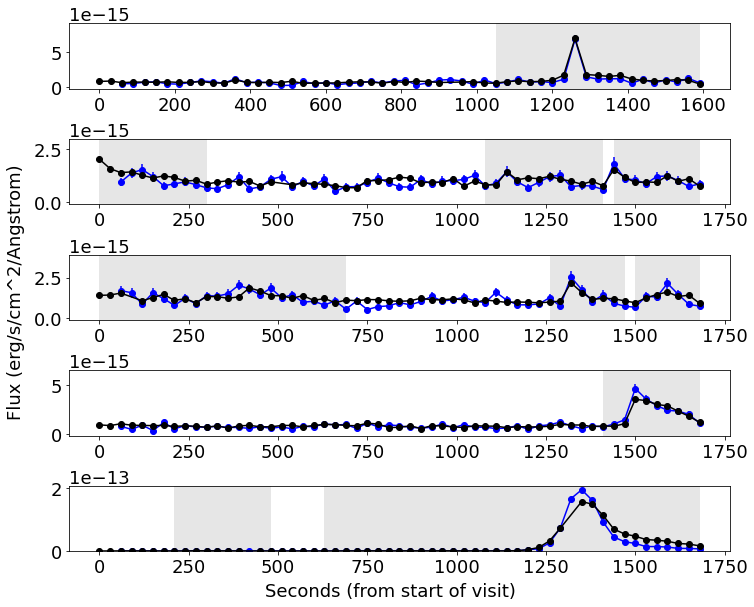

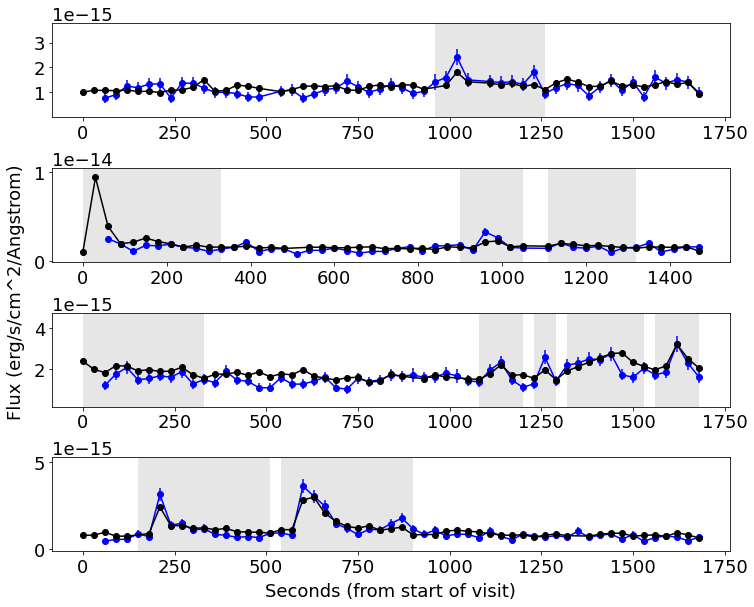

In [31]:
# Creates the figure used in the main part of the paper.
visit_arr = [0,1,2,3,4]
fig, axs = plt.subplots(len(visit_arr), 1, figsize=(10, 8), constrained_layout=True)
for ii,i in enumerate(visit_arr):
    lc_nuv = read_lightcurve(photon_files['NUV'][i])
    lc_fuv = read_lightcurve(photon_files['FUV'][i])
    # Ignore any data points that have bad time bins.  NOTE: THIS ASSUMES A 30-SECOND BIN SIZE.
    where_plot_fuv_full = np.where(lc_fuv['expt'] >= 20.0)[0]
    where_plot_nuv_full = np.where(lc_nuv['expt'] >= 20.0)[0]
    axs[ii].errorbar((lc_fuv['t0']-min(lc_nuv['t0']))[where_plot_fuv_full], lc_fuv['flux'][where_plot_fuv_full],
                 yerr=1.*lc_fuv['flux_err'][where_plot_fuv_full], fmt='-bo')
    axs[ii].errorbar((lc_nuv['t0']-min(lc_nuv['t0']))[where_plot_nuv_full], lc_nuv['flux'][where_plot_nuv_full],
                 yerr=1.*lc_nuv['flux_err'][where_plot_nuv_full], fmt='-ko')
    ylim = [min([min((lc_nuv['flux']-4*lc_nuv['flux_err'])[where_plot_nuv_full]),
                       min((lc_fuv['flux']-4*lc_fuv['flux_err'])[where_plot_fuv_full])]),
                  max([max((lc_nuv['flux']+4*lc_nuv['flux_err'])[where_plot_nuv_full]),
                       max((lc_fuv['flux']+4*lc_fuv['flux_err'])[where_plot_fuv_full])])]
    axs[ii].set_ylim(ylim)
    # Create shade regions for each flare in this visit.
    for fr, vn in zip(flare_table['flare_range'], flare_table['visit_num']):
        if int(vn) == i:
            mint = (lc_nuv['t0']-lc_nuv['t0'][0])[min(fr)]
            maxt = (lc_nuv['t0']-lc_nuv['t0'][0])[max(fr)]
            axs[ii].fill([mint, maxt, maxt, mint], [-999, -999, 999, 999], '0.9')
fig.text(0.5, -0.02, 'Seconds (from start of visit)', ha='center', va='center')
fig.text(-0.02, 0.5, 'Flux (erg/s/cm^2/Angstrom)', ha='center', va='center', rotation='vertical')
fig.savefig('figures/all_visits_01.eps', dpi=600)



visit_arr = [5,6,7,8]
fig, axs = plt.subplots(len(visit_arr), 1, figsize=(10, 8), constrained_layout=True)
for ii,i in enumerate(visit_arr):
    lc_nuv = read_lightcurve(photon_files['NUV'][i])
    lc_fuv = read_lightcurve(photon_files['FUV'][i])
    # Ignore any data points that have bad time bins.  NOTE: THIS ASSUMES A 30-SECOND BIN SIZE.
    where_plot_fuv_full = np.where(lc_fuv['expt'] >= 20.0)[0]
    where_plot_nuv_full = np.where(lc_nuv['expt'] >= 20.0)[0]
    axs[ii].errorbar((lc_fuv['t0']-min(lc_nuv['t0']))[where_plot_fuv_full], lc_fuv['flux'][where_plot_fuv_full],
                 yerr=1.*lc_fuv['flux_err'][where_plot_fuv_full], fmt='-bo')
    axs[ii].errorbar((lc_nuv['t0']-min(lc_nuv['t0']))[where_plot_nuv_full], lc_nuv['flux'][where_plot_nuv_full],
                 yerr=1.*lc_nuv['flux_err'][where_plot_nuv_full], fmt='-ko')
    ylim = [min([min((lc_nuv['flux']-4*lc_nuv['flux_err'])[where_plot_nuv_full]),
                       min((lc_fuv['flux']-4*lc_fuv['flux_err'])[where_plot_fuv_full])]),
                  max([max((lc_nuv['flux']+4*lc_nuv['flux_err'])[where_plot_nuv_full]),
                       max((lc_fuv['flux']+4*lc_fuv['flux_err'])[where_plot_fuv_full])])]
    axs[ii].set_ylim(ylim)
    # Create shade regions for each flare in this visit.
    for fr, vn in zip(flare_table['flare_range'], flare_table['visit_num']):
        if int(vn) == i:
            mint = (lc_nuv['t0']-lc_nuv['t0'][0])[min(fr)]
            maxt = (lc_nuv['t0']-lc_nuv['t0'][0])[max(fr)]
            axs[ii].fill([mint, maxt, maxt, mint], [-999, -999, 999, 999], '0.9')
fig.text(0.5, -0.02, 'Seconds (from start of visit)', ha='center', va='center')
fig.text(-0.02, 0.5, 'Flux (erg/s/cm^2/Angstrom)', ha='center', va='center', rotation='vertical')
fig.savefig('figures/all_visits_02.eps', dpi=600)

In [32]:
# Make the table of flare properties in the paper.
# Reformat the energy measurements to include error bars and reasonable sigfigs
nuv_energy_string, fuv_energy_string = [], []
for e, e_err in zip(np.array(np.log10(flare_table['energy_nuv']), dtype='float16'),
                   np.array(np.log10(flare_table['energy_err_nuv']), dtype='float16')):
    nuv_energy_string += ['{:4.2f} pm {:4.2f}'.format(e, e_err, 2)]
for e, e_err in zip(np.array(np.log10(flare_table['energy_fuv']), dtype='float16'),
                   np.array(np.log10(flare_table['energy_err_fuv']), dtype='float16')):
    fuv_energy_string += ['{:4.2f} pm {:4.2f}'.format(e, e_err, 2)]

# Reformat the peak timestamps
t = pd.to_datetime(flare_table['peak_t0_nuv'] + gt.GPSSECS, unit='s')
t.iloc[np.where(np.array(flare_table['peak_censored'], dtype='bool'))] = 'peak not measured'

# Convert key columns in the flare table into a format suitable for printing in a LaTeX table
summary_table = pd.DataFrame({
    'Flare':np.array(flare_table['flare_num'],dtype='int16'),
    'Visit':np.array(flare_table['visit_num'],dtype='int16')+1,
    'NUV Peak Time (UTC)':t,
    'Duration':np.array(flare_table['duration']/60.,dtype='float16'),
    'log(E_NUV)*':nuv_energy_string,
    'log(E_FUV)':fuv_energy_string,
    'NUV Strength':flare_table['nuv_sn'],
})
print(summary_table.to_latex(index=False))

\begin{tabular}{rrlrllr}
\toprule
 Flare &  Visit & NUV Peak Time (UTC) &  Duration &    log(E\_NUV)* &     log(E\_FUV) &  NUV Strength \\
\midrule
     1 &      1 & 2005-11-18 06:54:45 &       9.5 & 29.45 pm 27.92 & 28.86 pm 27.84 &      8.498467 \\
     2 &      2 &   peak not measured &       5.5 & 28.95 pm 27.80 & 28.00 pm 27.64 &      1.761480 \\
     3 &      2 & 2005-11-18 08:30:49 &       6.0 & 28.59 pm 27.77 & 27.92 pm 27.67 &      1.185004 \\
     4 &      2 &   peak not measured &       4.5 & 28.56 pm 27.70 & 28.12 pm 27.66 &      1.293150 \\
     5 &      3 & 2005-11-18 11:54:02 &      12.0 & 29.17 pm 27.97 & 28.64 pm 27.89 &      1.397152 \\
     6 &      3 & 2005-11-18 11:48:02 &       4.0 & 28.69 pm 27.72 & 28.28 pm 27.67 &      1.660546 \\
     7 &      3 & 2005-11-18 11:48:32 &       3.5 & 28.61 pm 27.69 & 28.14 pm 27.62 &      1.184765 \\
     8 &      4 & 2005-11-18 18:22:56 &       5.0 & 29.42 pm 27.88 & 29.02 pm 27.83 &      3.686975 \\
     9 &      5 & 2005-11-18